In [1]:
import warnings, random, gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from keras import layers

MAX_EPISODE = 100
GAMMA = 0.99
TAU=0.005
EPS = 1e-8
REPLAY_BUFFER_MAX_LEN = 50000
BATCH_SIZE = 64
UPDATE_TARGET_NETWORK = 500


warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Define the algorithm component

In [2]:
def get_actor_model(input_shape, output_shape, hidden_size, act_max_val):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(hidden_size, activation='relu')(inputs)
    x = layers.Dense(hidden_size, activation='relu')(x)
    outputs = layers.Dense(output_shape, activation='tanh', kernel_initializer=last_init)(x)
    
    outputs = outputs * act_max_val
    return keras.Model(inputs=inputs, outputs=outputs)

def get_critic_model(state_input_shape, action_input_shape):
   # State as input
    state_input = layers.Input(shape=(state_input_shape))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(action_input_shape))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    return keras.Model([state_input, action_input], outputs)

In [3]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def store(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)
    
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

train loop

In [4]:
env = gym.make("Pendulum-v1") 
# env = gym.make("LunarLandingContinuous-v2")

states_shape = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
act_upper_val = env.action_space.high[0]
act_lower_val = env.action_space.low[0]

actor = get_actor_model(input_shape=states_shape,
                        output_shape=n_actions,
                        hidden_size=256,
                        act_max_val=act_upper_val
)
target_actor = get_actor_model(input_shape=states_shape,
                               output_shape=n_actions,
                               hidden_size=256,
                               act_max_val=act_upper_val
)
critic = get_critic_model(state_input_shape=states_shape,
                          action_input_shape=n_actions
)
target_critic = get_critic_model(state_input_shape=states_shape,
                                 action_input_shape=n_actions
)
target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

replay_buffer = ReplayBuffer(REPLAY_BUFFER_MAX_LEN)
action_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))

actor_optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
critic_optimizer = keras.optimizers.legacy.Adam(learning_rate=0.002)

episode_rewards = []
avg_rewards = []
running_reward = 0
for episode in range(1, MAX_EPISODE+1):
    state, _ = env.reset()
    episode_reward = 0
    
    for i in range(200):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        actor_out = actor(state_tensor)
        actor_out = tf.squeeze(actor_out).numpy() + action_noise()
        action = np.clip(actor_out, act_lower_val, act_upper_val)
        action = [np.squeeze(action)]
        
        next_state, reward, done, _, _ = env.step(action)

        replay_buffer.store(state, action, reward, next_state, done)
        episode_reward += reward
        
        state = next_state
        
        if len(replay_buffer) > BATCH_SIZE:
            states, actions, rewards, next_states, _ = replay_buffer.sample(BATCH_SIZE)
            states = tf.convert_to_tensor(states)
            actions = tf.convert_to_tensor(actions)
            next_states = tf.convert_to_tensor(next_states)
            
            with tf.GradientTape() as tape:
                next_actions = target_actor(next_states, training=True)
                next_q = target_critic([next_states, next_actions],  training=True)
                y = rewards + GAMMA * next_q
                q_values = critic([states, actions], training=True)
                critic_loss = tf.math.reduce_mean(tf.math.square(y - q_values))
            
            critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
            
            with tf.GradientTape() as tape:
                actor_actions = actor(states, training=True)
                q_values = critic([states, actor_actions],  training=True)
                actor_loss = -tf.math.reduce_mean(q_values)
                
            actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
            actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    
            # update the the target network with new weights
            for (a, b) in zip(target_actor.variables, actor.variables):
                a.assign(b * TAU + a * (1 - TAU))
                
            for (a, b) in zip(target_critic.variables, critic.variables):
                a.assign(b * TAU + a * (1 - TAU))
                            
        if done:
            break
        
    episode_rewards.append(episode_reward)
    avg_reward = np.mean(episode_rewards[-40:])
    avg_rewards.append(avg_reward)
    
    print(f"Episode {episode}:\aavg_reward={avg_reward:.1f}\tactor_loss={actor_loss:.3f}\tcritic_loss={critic_loss:.3f}")

Episode 1:avg_reward=-1406.9	actor_loss=8.618	critic_loss=0.655
Episode 2:avg_reward=-1478.1	actor_loss=14.515	critic_loss=0.075
Episode 3:avg_reward=-1525.4	actor_loss=19.345	critic_loss=0.031
Episode 4:avg_reward=-1527.4	actor_loss=25.612	critic_loss=0.028
Episode 5:avg_reward=-1526.2	actor_loss=32.939	critic_loss=0.274
Episode 6:avg_reward=-1514.9	actor_loss=38.013	critic_loss=0.075
Episode 7:avg_reward=-1514.1	actor_loss=45.169	critic_loss=0.049
Episode 8:avg_reward=-1513.6	actor_loss=51.707	critic_loss=0.164
Episode 9:avg_reward=-1492.8	actor_loss=56.785	critic_loss=0.190
Episode 10:avg_reward=-1494.1	actor_loss=64.272	critic_loss=2.306
Episode 11:avg_reward=-1461.9	actor_loss=69.628	critic_loss=0.641
Episode 12:avg_reward=-1436.1	actor_loss=71.674	critic_loss=0.509
Episode 13:avg_reward=-1412.1	actor_loss=73.812	critic_loss=0.844
Episode 14:avg_reward=-1385.8	actor_loss=83.579	critic_loss=0.717
Episode 15:avg_reward=-1374.9	actor_loss=86.741	critic_loss=2.055
Episo

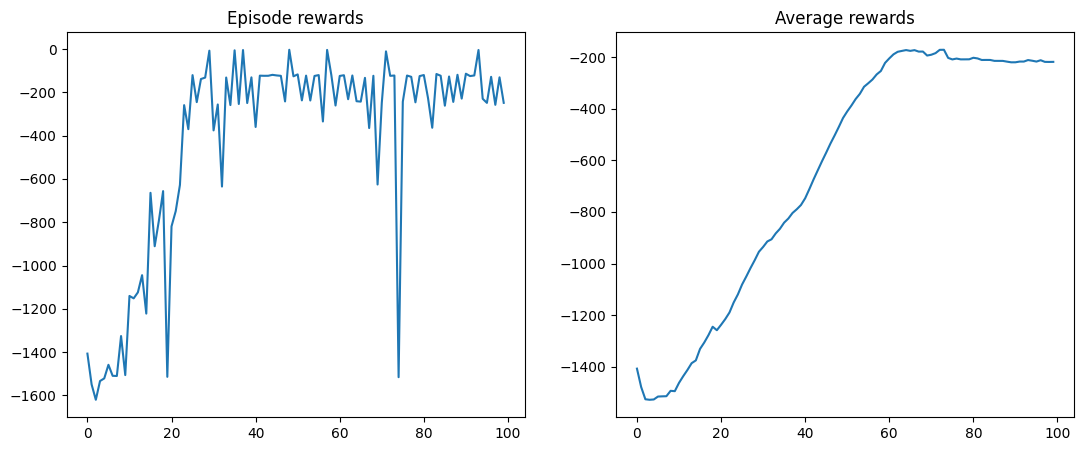

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.plot(episode_rewards)
ax1.set_title("Episode rewards")
ax2.plot(avg_rewards)
ax2.set_title("Average rewards")
plt.show()